## Applied Natural Language Processing - Method 1
triditional way of NLP

In [31]:
# import the package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import string 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from collections import Counter, OrderedDict
from collections import defaultdict
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
# import en_core_web_lg
import spacy 
nlp = spacy.load("en_core_web_lg")
# import en_core_web_sm
# nlp = en_core_web_sm.load()
import tomotopy as tp
from gensim.models import Phrases
from rich.console import Console
from rich.table import Table
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
from tracemalloc import stop
from langcodes import best_match
from matplotlib import rc
import matplotlib.pyplot as plt
from gensim.models import Phrases
import pickle # for spelling chcker
from rich.console import Console
from rich.table import Table
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# BERT
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import random
# from transformers import BertTokenizer,BertModel,get_linear_schedule_with_warmup 
# import nlpaug.augmenter.sentence as nas
# import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.word as naw

from numpy import zeros
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier # rf 
from sklearn.tree import DecisionTreeClassifier, plot_tree # dt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
import keras_tuner as kt

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Overlooking the data

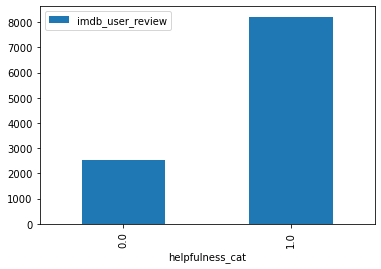

In [5]:
# # load the data
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
final_result = pd.read_csv('final_result.csv')

# check the distribution of the dataset by category
df.groupby('helpfulness_cat').count().plot.bar(ylim=0)
plt.show()

# 2. Data Preprocessing

## 2.1. Cleaning the text & Changing to token Define Function
Below is the defone function for cleaning and tokenizing the text.
Including preprocess, clean_tokens, (clean_data), and postprocess

In [7]:
#################################################### define function to clean the text #################################################### 
def preprocess(text):
    # stemmer = PorterStemmer()
    # stopwords_english = stopwords.words('english')
    pattern = re.compile(r'\s+')
    text=text.replace('\u202f',' ').replace('xa0',' ')
    # remove Unicode Characters (punctuation, emoji,rul and @)
    text=re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text=re.sub(r"\\u00b4",r'',text)
    text=re.sub(pattern, ' ', text)
    text = str(text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'#', '', text)
    text = text.replace('?', ' ? ').replace(')', ') ').strip()
    return text

##################################################### define function to change to tokens ####################################################
def clean_tokens(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # step 2: change the list to lower case
    text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

##################################################### define function to change to tokens ####################################################
def postprocess(text): # for the usage of augmentation data
  return text[2:-2]

In [4]:
# df apply preprocess function
df['imdb_user_review_clean'] = df['imdb_user_review'].apply(preprocess)
df['token'] = clean_tokens(df['imdb_user_review'])

100%|██████████| 10755/10755 [05:12<00:00, 34.40it/s]


In [8]:
# # save df to csv
# df.to_csv('df.csv', index=False) #here is the file path
df = pd.read_csv('df.csv') #here is the file path
df

,helpfulness_cat,imdb_user_review,imdb_user_review_clean,token
0,1.0,It is hard to find such delightful and adorabl...,It is hard to find such delightful and adorabl...,"['hard', 'delightful', 'adorable', 'movie', 'd..."
1,1.0,"They don't make films like this faded, hauntin...",They dont make films like this faded haunting ...,"['film', 'fade', 'haunt', 'masterpiece', 'sile..."
2,1.0,I first viewed this movie in 1924 at age 6 yrs...,I first viewed this movie in 1924 at age 6 yrs...,"['view', 'movie', 'age', 'yr', 'movie', 'think..."
3,1.0,I doubt that I'd ever seen anything resembling...,I doubt that Id ever seen anything resembling ...,"['doubt', 'resemble', 'version', 'metropolis',..."
4,1.0,I was shocked to find myself riveted to this m...,I was shocked to find myself riveted to this m...,"['shocked', 'rivet', 'movie', 'doubt', 'sci', ..."
...,...,...,...,...
10750,0.0,The makers of this movie really touched a sore...,The makers of this movie really touched a sore...,"['maker', 'movie', 'touch', 'sore', 'spot', 'g..."
10751,0.0,I Care A Lot is an exhilarating black comedy w...,I Care A Lot is an exhilarating black comedy w...,"['care', 'lot', 'exhilarating', 'black', 'come..."
10752,0.0,Really loved this. This film is masterful in t...,Really loved this This film is masterful in th...,"['love', 'film', 'masterful', 'feel', 'charact..."
10753,0.0,"The story, direction and acting across the boa...",The story direction and acting across the boar...,"['story', 'direction', 'act', 'board', 'superb..."


## 2.2. Data Splitting (train, test, validation)

In [9]:
def Data_Splitting(X, y):
    # split dataset into 70% train, 30% test
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y) 
    # reset the index
    train_x=train_x.reset_index(drop=True)
    test_x=test_x.reset_index(drop=True)
    train_y=train_y.reset_index(drop=True)
    test_y=test_y.reset_index(drop=True)
    # verifying the data distribution
    print('train_x:',train_x.shape,'test_x:', test_x.shape)
    # verifying if the split between classes is preserved
    print('train_y mean:', train_y.mean())
    print( 'test_y mean:', test_y.mean())
    return train_x, test_x, train_y, test_y

In [10]:
X = df.drop(['helpfulness_cat'], axis=1)
y = df['helpfulness_cat']
train_x, test_x, train_y, test_y = Data_Splitting(X, y)

train_x: (7528, 3) test_x: (3227, 3)
train_y mean: 0.763682252922423
test_y mean: 0.7638673690734429


In [11]:
# combine train_x and train_y for the usage of augmentation
train_xy = pd.concat([train_x, train_y], axis=1)
train_xy

,imdb_user_review,imdb_user_review_clean,token,helpfulness_cat
0,"I watched this movie and three years later, it...",I watched this movie and three years later its...,"['watch', 'movie', 'year', 'good', 'actor', 'g...",1.0
1,...This movie would be a real treat...I enjoy'...,This movie would be a real treatI enjoyd this ...,"['movie', 'real', 'treat', 'movie', 'wonder', ...",1.0
2,Take everything good about the 1st X-men movie...,Take everything good about the 1st Xmen movie ...,"['good', 'x', 'man', 'movie', 'sprinkle', 'das...",1.0
3,"Finn was terrible, Rey was terrible. They even...",Finn was terrible Rey was terrible They even m...,"['finn', 'terrible', 'rey', 'terrible', 'yoda'...",1.0
4,I've seen this movie more times than I can cou...,Ive seen this movie more times than I can coun...,"['movie', 'time', 'count', 'time', 'theater', ...",1.0
...,...,...,...,...
7523,This is possibly one of the best films I have ...,This is possibly one of the best films I have ...,"['film', 'start', 'finish', 'feel', 'inaudible...",1.0
7524,I heard Oldboy was a movie that should not be ...,I heard Oldboy was a movie that should not be ...,"['hear', 'oldboy', 'movie', 'miss', 'agree', '...",0.0
7525,I find the relationship between the Doc and hi...,I find the relationship between the Doc and hi...,"['relationship', 'doc', 'teen', 'friend', 'hig...",0.0
7526,"I was excited to see \""This is it\"" because I ...",I was excited to see This is it because I was ...,"['excited', 'michael', 'jackson', 'fan', 'arti...",0.0


## 2.3. Data Balancing (0 & 1) with Augmentation

In [ ]:
def aug_abstract(text):
  aug = nas.abst_summ.AbstSummAug(model_path='t5-base')
  augmented_text=aug.augment(text) # augmented_text is the summary of the review
  return augmented_text

def aug_crop(text):
  aug1=naw.RandomWordAug(action='crop',aug_p=0.5) # Randomly delete sentences
  aug2=naw.SynonymAug(aug_src='wordnet') # synonym substitution
  aug3 = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute") # Replace sentences based on context
  return aug3.augment(aug2.augment(aug1.augment(text))) 

In [ ]:
df_aug =train_xy[train_xy['helpfulness_cat']==0].copy()
df_aug= df_aug[['imdb_user_review_clean','helpfulness_cat']]
df_aug=df_aug.reset_index(drop=True)

df_aug['augmented_text1']=df_aug['imdb_user_review'].apply(aug_abstract)
df_aug['augmented_text2']=df_aug['imdb_user_review'].apply(aug_crop)

# # on the local file
# df_aug.to_csv('/Users/timliu/Documents/GitHub/NLP_courseproject/NLP_dataset/df_aug.csv')

# # on the colab
# os.chdir('/content/drive/My Drive')
# df_aug.to_csv('df_aug.csv')

In [12]:
# # read the csv
df_aug = pd.read_csv('df_aug.csv') 

In [13]:
df_aug1=df_aug.loc[:,('helpfulness_cat','augmented_text1')].rename(columns={"augmented_text1":"imdb_user_review"})
df_aug1['imdb_user_review']=df_aug1['imdb_user_review'].apply(postprocess) # apply the postprocess function to remove [] and ''
df_aug2=df_aug.loc[:,('helpfulness_cat','augmented_text2')].rename(columns={"augmented_text2":"imdb_user_review"})
df_aug2['imdb_user_review']=df_aug2['imdb_user_review'].apply(postprocess) # apply the postprocess function to remove [] and ''

In [14]:
train_xy=pd.concat((train_xy[['imdb_user_review','helpfulness_cat']],df_aug1,df_aug2),axis=0)
train_xy=train_xy.reset_index(drop=True)
# apply preprocess function
train_xy['imdb_user_review_clean'] = train_xy['imdb_user_review'].apply(preprocess)
train_xy['token'] = clean_tokens(train_xy['imdb_user_review'])
# seperate the train_x and train_y
train_x=train_xy.drop(['helpfulness_cat'], axis=1)
train_y=train_xy['helpfulness_cat']

100%|██████████| 11080/11080 [04:35<00:00, 40.23it/s]


In [16]:
# save the train_x and train_y to csv
train_x.to_csv('/Users/timliu/Desktop/train_x.csv', index=False) #here is the file path
train_y.to_csv('/Users/timliu/Desktop/train_y.csv', index=False) #here is the file path

# 3. Changing into Vector

## 3.1 BoW

In [15]:
# zip
train_xy = pd.concat([train_x, train_y], axis=1)
test_xy = pd.concat([test_x, test_y], axis=1)
traintest_xy = pd.concat((train_xy, test_xy), axis=0)
traintest_xy = traintest_xy.reset_index(drop=True)
traintest_xy

,imdb_user_review,imdb_user_review_clean,token,helpfulness_cat
0,"I watched this movie and three years later, it...",I watched this movie and three years later its...,"[watch, movie, year, good, actor, good, wither...",1.0
1,...This movie would be a real treat...I enjoy'...,This movie would be a real treatI enjoyd this ...,"[movie, real, treat, movie, wonder, good, movi...",1.0
2,Take everything good about the 1st X-men movie...,Take everything good about the 1st Xmen movie ...,"[good, x, man, movie, sprinkle, dash, maise, w...",1.0
3,"Finn was terrible, Rey was terrible. They even...",Finn was terrible Rey was terrible They even m...,"[finn, terrible, rey, terrible, yoda, terrible...",1.0
4,I've seen this movie more times than I can cou...,Ive seen this movie more times than I can coun...,"[movie, time, count, time, theater, root, win,...",1.0
...,...,...,...,...
14302,I cannot say anything else that has not been s...,I cannot say anything else that has not been s...,"['plot', 'woman', 'hilary', 'swank', 'daughter...",1.0
14303,Down the Road shows every film maker trying to...,Down the Road shows every film maker trying to...,"['road', 'film', 'maker', 'real', 'talent', 'm...",0.0
14304,"Just watch it, words don't justify it! People ...",Just watch it words dont justify it People did...,"['watch', 'justify', 'people', 'sly', 'wrong',...",1.0
14305,"Ok, basically this is a popcorn sci-fi movie, ...",Ok basically this is a popcorn scifi movie but...,"['basically', 'popcorn', 'sci', 'movie', 'outs...",1.0


In [16]:
vectorizer = CountVectorizer()
def Bow(text_series):
    # Create sample set of documents
    text_series = text_series.to_list()
    docs = np.array(text_series)
    # Fit the bag-of-words model
    bag = vectorizer.fit_transform(docs)
    # # Get unique words / tokens found in all the documents. The unique words / tokens represents the features
    # print(vectorizer.get_feature_names())
    # # Associate the indices with each unique word
    # print(vectorizer.vocabulary_)
    df = pd.DataFrame(bag.toarray())
    return df

traintest_xy_bow = Bow(traintest_xy['imdb_user_review'])
traintest_xy_bow['helpfulness_cat'] = traintest_xy['helpfulness_cat']
traintest_xy_bow

,0,1,2,3,4,5,6,7,8,9,...,46633,46634,46635,46636,46637,46638,46639,46640,46641,helpfulness_cat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
14303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
14304,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
14305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [17]:
# unzip
train_xy_bow,test_xy_bow = traintest_xy_bow.iloc[:len(train_xy),:],traintest_xy_bow.iloc[len(train_xy):,:]
train_x_bow, train_y_bow = train_xy_bow.drop(['helpfulness_cat'], axis=1), train_xy_bow['helpfulness_cat']
test_x_bow, test_y_bow = test_xy_bow.drop(['helpfulness_cat'], axis=1), test_xy_bow['helpfulness_cat']

## 3.2 Word2Vec
word2vec model and parameters:
- vector size = Wword vector dimensionality                      
- min_count = Minimum word count to be included for training                      
- workers = number of threads to run in parallel
- window = context window size                                                                                    
- sample = downsample setting for frequent words

In [18]:
def W2V_function(text_series):
   text_list = text_series.tolist()
   model_w2v = Word2Vec(
      text_list,
      size=300,
      window=10, 
      min_count=40,
      sample=1e-3, 
      workers=4
      )
   def featurize_w2v(model, train):
      f = zeros((len(train), model.vector_size))
      for i,s in enumerate(train):
         for w in s:
               try:
                  vec = model.wv[w]
               except KeyError:
                  continue
               f[i,:] = f[i,:] + vec
         f[i,:] = f[i,:] / len(s)
      return f
   features_w2v = featurize_w2v(model_w2v, text_list)
   return features_w2v

traintest_x_w2v_array = W2V_function(traintest_xy['token'])
# use np.where to detect the nan
nan_index = np.unique(np.where(np.isnan(traintest_x_w2v_array))[0])
traintest_x_w2v_na = pd.DataFrame(traintest_x_w2v_array)
# remove the rows from nan_index
traintest_x_w2v = traintest_x_w2v_na.drop(traintest_x_w2v_na.index[nan_index])
# traintest_xy['helpfulness_cat'] remove the rows from nan_index
traintest_y_w2v = traintest_xy[['helpfulness_cat']].drop(traintest_xy[['helpfulness_cat']].index[nan_index])
# concat  to traintest_xy_w2v
traintest_xy_w2v = pd.concat((traintest_x_w2v, traintest_y_w2v), axis=1)
traintest_xy_w2v

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_75845/105227311.py:20: RuntimeWarning: invalid value encountered in true_divide
  f[i,:] = f[i,:] / len(s)


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,helpfulness_cat
0,-0.066840,-0.172254,-0.235592,0.069654,0.105220,0.163784,-0.043430,0.050929,-0.062178,0.195088,...,-0.171321,-0.331463,-0.144832,0.002233,-0.103967,0.031216,-0.392024,-0.060639,-0.063877,1.0
1,-0.058777,0.007152,-0.019339,-0.125024,0.100984,0.126183,-0.021403,0.170868,-0.279188,0.191285,...,-0.127011,-0.681528,-0.249685,0.107657,-0.324103,0.226821,-0.604013,-0.374176,-0.037813,1.0
2,0.015551,0.057952,0.000804,-0.037528,0.085590,0.058209,-0.003686,0.135935,-0.152631,0.188997,...,-0.073426,-0.310078,-0.138659,-0.016805,-0.113694,0.102471,-0.299900,-0.193262,-0.044000,1.0
3,0.033651,0.025468,-0.064862,0.087138,0.228751,0.207846,0.031042,0.135009,-0.237574,0.262268,...,-0.093919,-0.120344,0.003962,-0.095184,-0.090026,0.008409,0.081969,-0.056976,0.015034,1.0
4,-0.012324,0.187096,0.108069,-0.199157,0.070703,0.110309,-0.095994,-0.043794,0.002911,0.020908,...,0.107260,-0.075059,-0.027701,0.052156,-0.039387,0.073363,-0.242260,-0.127305,-0.007969,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14302,-0.220043,-1.796817,-1.090470,0.782279,0.959205,1.618121,-0.817467,0.457538,0.059958,0.084512,...,-0.016515,0.442793,0.243181,0.111872,0.286931,-0.337123,0.810128,0.717293,-0.020927,1.0
14303,-0.221555,-1.793855,-1.081683,0.780822,0.977918,1.653321,-0.828809,0.470037,0.067979,0.068104,...,-0.015163,0.428388,0.236102,0.125527,0.278946,-0.339535,0.808867,0.722166,-0.022187,0.0
14304,-0.218730,-1.775839,-1.076021,0.768326,0.960989,1.631270,-0.818492,0.457680,0.056371,0.079255,...,-0.012771,0.436341,0.240705,0.120700,0.280752,-0.334222,0.804379,0.711122,-0.020362,1.0
14305,-0.222168,-1.746028,-1.050471,0.751414,0.963557,1.632966,-0.822507,0.462176,0.053621,0.085825,...,-0.019489,0.420953,0.229686,0.117799,0.273408,-0.328662,0.783797,0.701133,-0.023399,1.0


In [19]:
# unzip
train_xy_w2v,test_xy_w2v = traintest_xy_w2v.iloc[:(len(train_xy)-5),:],traintest_xy_w2v.iloc[(len(train_xy)-5):,:]
train_x_w2v, train_y_w2v = train_xy_w2v.drop(['helpfulness_cat'], axis=1), train_xy_w2v['helpfulness_cat']
test_x_w2v, test_y_w2v = test_xy_w2v.drop(['helpfulness_cat'], axis=1), test_xy_w2v['helpfulness_cat']

## 3.3 TF-IDF

In [20]:
test_xy=pd.concat((test_x,test_y),axis=1)
traintest_xy=pd.concat((train_xy,test_xy),axis=0)
# if traintest_xy['token'] is a empty list, drop
traintest_xy['token_len'] = traintest_xy['token'].apply(len)
# if  traintest_xy['token_len'] = 0, drop
traintest_xy = traintest_xy.drop(traintest_xy[traintest_xy['token_len'] == 0].index)
# reset the index
traintest_xy = traintest_xy.reset_index(drop=True)
traintest_xy

,imdb_user_review,imdb_user_review_clean,token,helpfulness_cat,token_len
0,"I watched this movie and three years later, it...",I watched this movie and three years later its...,"[watch, movie, year, good, actor, good, wither...",1.0,15
1,...This movie would be a real treat...I enjoy'...,This movie would be a real treatI enjoyd this ...,"[movie, real, treat, movie, wonder, good, movi...",1.0,37
2,Take everything good about the 1st X-men movie...,Take everything good about the 1st Xmen movie ...,"[good, x, man, movie, sprinkle, dash, maise, w...",1.0,28
3,"Finn was terrible, Rey was terrible. They even...",Finn was terrible Rey was terrible They even m...,"[finn, terrible, rey, terrible, yoda, terrible...",1.0,29
4,I've seen this movie more times than I can cou...,Ive seen this movie more times than I can coun...,"[movie, time, count, time, theater, root, win,...",1.0,48
...,...,...,...,...,...
14297,I cannot say anything else that has not been s...,I cannot say anything else that has not been s...,"['plot', 'woman', 'hilary', 'swank', 'daughter...",1.0,499
14298,Down the Road shows every film maker trying to...,Down the Road shows every film maker trying to...,"['road', 'film', 'maker', 'real', 'talent', 'm...",0.0,475
14299,"Just watch it, words don't justify it! People ...",Just watch it words dont justify it People did...,"['watch', 'justify', 'people', 'sly', 'wrong',...",1.0,491
14300,"Ok, basically this is a popcorn sci-fi movie, ...",Ok basically this is a popcorn scifi movie but...,"['basically', 'popcorn', 'sci', 'movie', 'outs...",1.0,340


In [36]:
def simple_logistic_classify(x_train, x_test,y_train, y_test):
    model = LogisticRegression(C=1.0).fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    score = model.score(x_test, y_test)
    print(score)
    return score,model,y_pred

# select n-gram
# train model with different n-gram ranges
for N in tqdm(range(1,4)):
    vectorizer = TfidfVectorizer(ngram_range=(1,N), max_features=40000)
    tfidf_output = vectorizer.fit_transform(np.array(traintest_xy['imdb_user_review_clean']))
    x = vectorizer.get_feature_names()  # get_feature_names_out
    # contact the result of tfidf and index
    df_tfidfvect = pd.DataFrame(data = tfidf_output.toarray(),columns = x)
    train_x_tfidf,test_x_tfidf = df_tfidfvect.iloc[:(len(train_xy)-5),:],df_tfidfvect.iloc[(len(train_xy)-5):,:]
    train_y_tfidf, test_y_tfidf = traintest_xy[['helpfulness_cat']].iloc[:(len(train_xy)-5),:],traintest_xy[['helpfulness_cat']].iloc[(len(train_xy)-5):,:]

    # compute f-1 score
    model = simple_logistic_classify(train_x_tfidf, test_x_tfidf, train_y_tfidf, test_y_tfidf)
    print('F-1 score of model with n-gram range of {}: {}'.format((1,N),model))

 33%|███▎      | 1/3 [00:18<00:37, 18.97s/it]

0.7499225286643941
F-1 score of model with n-gram range of (1, 1): (0.7499225286643941, LogisticRegression(), array([0., 1., 1., ..., 1., 1., 1.]))


 67%|██████▋   | 2/3 [00:32<00:15, 15.70s/it]

0.7474434459250078
F-1 score of model with n-gram range of (1, 2): (0.7474434459250078, LogisticRegression(), array([0., 1., 1., ..., 1., 1., 1.]))


100%|██████████| 3/3 [01:03<00:00, 21.33s/it]

0.7437248218159281
F-1 score of model with n-gram range of (1, 3): (0.7437248218159281, LogisticRegression(), array([0., 1., 1., ..., 1., 1., 1.]))


In [21]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=40000)
tfidf_output = vectorizer.fit_transform(np.array(traintest_xy['imdb_user_review_clean']))
x = vectorizer.get_feature_names()  # get_feature_names_out
# contact the result of tfidf and index
df_tfidfvect = pd.DataFrame(data = tfidf_output.toarray(),columns = x)
train_x_tfidf,test_x_tfidf = df_tfidfvect.iloc[:(len(train_xy)-5),:],df_tfidfvect.iloc[(len(train_xy)-5):,:]
train_y_tfidf, test_y_tfidf = traintest_xy[['helpfulness_cat']].iloc[:(len(train_xy)-5),:],traintest_xy[['helpfulness_cat']].iloc[(len(train_xy)-5):,:]

# 4. Benchmarking Model

## 4.1. Logistic Regression, Decision Tree, Random Forest Define Function
With only text vector input, We would use the define function regression to compare the performance of different vector and select the best one

In [22]:
# Creating the confusion matrix for the benchmarking and other models using
def c_m(y_test, y_pred):
    # Creating the confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Visualizing the Confusion Matrix
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.ylabel('Actual Results')
    plt.xlabel('Predicted Results')
    ax1.xaxis.set_label_position("top")

    print("Model's Accuracy:", (TP+TN)/(TN+TP+FN+FP))
    print("Model's Misclassification:", (FP+FN)/(TN+TP+FN+FP))
    print("Model's Specificity:", TN/(FP+TN))
    print("Model's Sensitivity:", TP/(TP+FN))

In [23]:
def logistic_regression(X_train, X_test, Y_train, Y_test):
    # Train logistic model on the training set
    logm_train = LogisticRegression(max_iter=2000).fit(X_train, Y_train) # .values.ravel()
    # print("Intercept = ",logm_train.intercept_)
    # print("Model coefficients = ", logm_train.coef_)
    print("train R^2 =",logm_train.score(X_train, Y_train))

    # Use test set to pick right threshold
    # fit the test data to the trained model
    Y_probs =logm_train.predict_proba(X_test)[:,1]
    # get the fpr tpr score
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,Y_probs)
    plt.plot(fpr, tpr, linewidth=4)
    plt.show()
    #check the ROC score
    print('test roc_auc_score',roc_auc_score(Y_test,Y_probs))
    # get the threshold
    threshold = thresholds[np.argmax(tpr - fpr)]
    print("test Threshold = ",threshold)

    # # Retraining the final model with X_train+X_test and Y_train+ Y_testdata
    # train_val_X = np.concatenate((X_train,X_test))
    # train_val_Y = np.concatenate((Y_train,Y_test))
    # # train_val_X = pd.concat([X_train, X_test])
    # # train_val_Y = pd.concat([Y_train, Y_test])

    # logm = LogisticRegression(max_iter=2000).fit(train_val_X, train_val_Y)
    # # print("Intercept = ",logm.intercept_)
    # # print("Model coefficients = ", logm.coef_)
    # print("R^2 =",logm.score(train_val_X, train_val_Y))

    Y_probs_val =logm_train.predict_proba(X_test)[:,1]
    Y_pred_val = np.where(Y_probs_val > threshold, 1, 0) #input the threshold
    c_m(Y_test, Y_pred_val)
    print(metrics.classification_report(Y_test, Y_pred_val))

In [24]:
# random forest: unpotimised model
def random_forest(X_train, X_test, Y_train, Y_test):
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, Y_train)
    print('Unoptimised Tree Accuracy')
    # get the confusion matrix
    y_pred = rf.predict(X_test)   
    print('==================')
    c_m(y_pred, Y_test)
    print('==================')
    print(metrics.classification_report(Y_test, y_pred))

In [27]:
# decision tree
def decision_tree(X_train, X_test, Y_train, Y_test):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, Y_train)
    y_pred = dt.predict(X_test)
    print("Accuracy is ", accuracy_score(Y_test,y_pred)*100)
    y_pred_proba = dt.predict_proba(X_test)[:,1]
    fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="test, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    # Evaluate test set accuracy
    print('Accuracy score (train set) = %0.4f'%accuracy_score(Y_train, dt.predict(X_train)))
    print('Accuracy score (test set) = %0.4f'%accuracy_score(Y_test, y_pred))
    print('F1 score (test set) = %0.4f'%f1_score(Y_test, y_pred))
    print('AUC score (test set) = %0.4f'%roc_auc_score(Y_test, y_pred_proba))
    # Plot confusion matrix  
    c_m(y_pred, Y_test)
    print('==================')
    print(metrics.classification_report(Y_test, y_pred))

## 4.2. Evaluation
Selecting the best vector accuracy

train R^2 = 0.9861913357400722


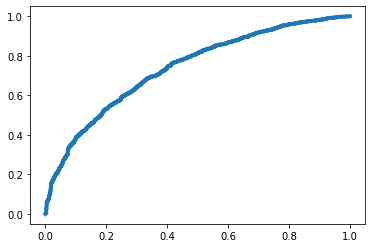

test roc_auc_score 0.7380769087434051
test Threshold =  0.7372672694941239
Model's Accuracy: 0.6808180973039976
Model's Misclassification: 0.3191819026960025
Model's Specificity: 0.6653543307086615
Model's Sensitivity: 0.6855983772819473
              precision    recall  f1-score   support

         0.0       0.40      0.67      0.50       762
         1.0       0.87      0.69      0.77      2465

    accuracy                           0.68      3227
   macro avg       0.63      0.68      0.63      3227
weighted avg       0.76      0.68      0.70      3227



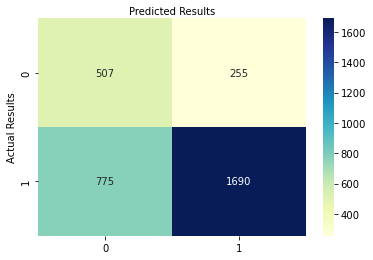

In [60]:
logistic_regression(train_x_bow, test_x_bow, train_y_bow, test_y_bow)

train R^2 = 0.6437020316027088


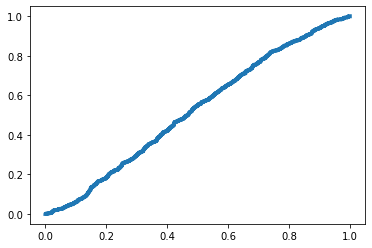

test roc_auc_score 0.5235192963962669
test Threshold =  3.072358475390557e-05
Model's Accuracy: 0.6867059188100403
Model's Misclassification: 0.3132940811899597
Model's Specificity: 0.25984251968503935
Model's Sensitivity: 0.8186612576064909
              precision    recall  f1-score   support

         0.0       0.31      0.26      0.28       762
         1.0       0.78      0.82      0.80      2465

    accuracy                           0.69      3227
   macro avg       0.54      0.54      0.54      3227
weighted avg       0.67      0.69      0.68      3227



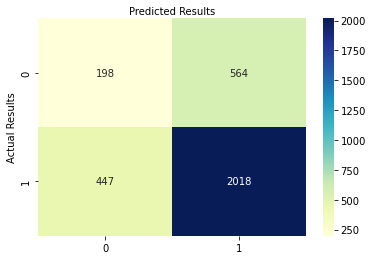

In [61]:
logistic_regression(train_x_w2v, test_x_w2v, train_y_w2v, test_y_w2v)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


train R^2 = 0.8837020316027088


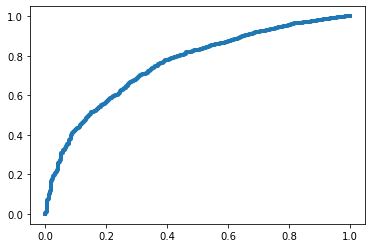

test roc_auc_score 0.7575202440465733
test Threshold =  0.596896932791225
Model's Accuracy: 0.6991013325069724
Model's Misclassification: 0.30089866749302757
Model's Specificity: 0.6902887139107612
Model's Sensitivity: 0.7018255578093306
              precision    recall  f1-score   support

         0.0       0.42      0.69      0.52       762
         1.0       0.88      0.70      0.78      2465

    accuracy                           0.70      3227
   macro avg       0.65      0.70      0.65      3227
weighted avg       0.77      0.70      0.72      3227



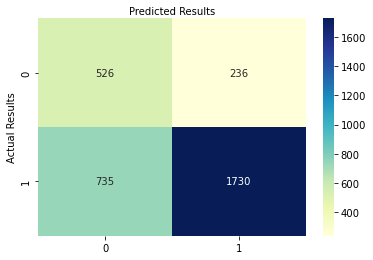

In [38]:
logistic_regression(train_x_tfidf, test_x_tfidf, train_y_tfidf, test_y_tfidf)

Accuracy is  62.101022621629994


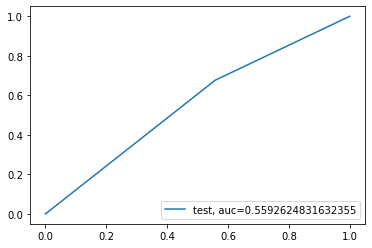

Accuracy score (train set) = 1.0000
Accuracy score (test set) = 0.6210
F1 score (test set) = 0.7316
AUC score (test set) = 0.5593
Model's Accuracy: 0.6210102262163
Model's Misclassification: 0.3789897737837
Model's Specificity: 0.29691629955947135
Model's Sensitivity: 0.7968451242829828
              precision    recall  f1-score   support

         0.0       0.30      0.44      0.36       762
         1.0       0.80      0.68      0.73      2465

    accuracy                           0.62      3227
   macro avg       0.55      0.56      0.54      3227
weighted avg       0.68      0.62      0.64      3227



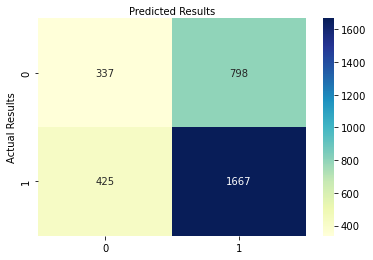

In [28]:
decision_tree(train_x_tfidf, test_x_tfidf, train_y_tfidf, test_y_tfidf)

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_75845/2626677571.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, Y_train)


Unoptimised Tree Accuracy
Model's Accuracy: 0.6960024790827394
Model's Misclassification: 0.3039975209172606
Model's Specificity: 0.36727272727272725
Model's Sensitivity: 0.8089092422980849
              precision    recall  f1-score   support

         0.0       0.37      0.40      0.38       762
         1.0       0.81      0.79      0.80      2465

    accuracy                           0.70      3227
   macro avg       0.59      0.59      0.59      3227
weighted avg       0.70      0.70      0.70      3227



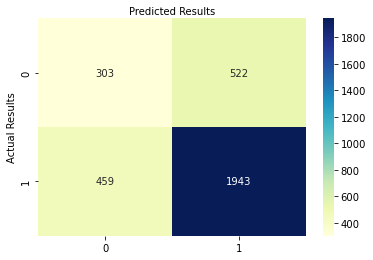

In [29]:
random_forest(train_x_tfidf, test_x_tfidf, train_y_tfidf, test_y_tfidf) 

In [53]:
# ---+ step 2 define a grid of parameters to search over
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in  np.linspace(start = 100, stop = 200, num = 11)]
max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [1, 2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1,2,3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
# purity of the leaf nodes

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
            #    'min_samples_split': min_samples_split,
            #    'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

# print out the random grid
print(random_grid)

{'n_estimators': [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, None], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [54]:
# ---+ step 3 use the grid to search for best model
# create the base model to tune
rf = RandomForestClassifier(random_state=0, min_samples_split=2, min_samples_leaf=1)
# random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = 4)
# fit the random search model
rf_random.fit(train_x_tfidf, train_y_tfidf.values.ravel())

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=130, max_features=auto, n_estimators=28; total time= 1.3min
[CV] END bootstrap=False, criterion=entropy, max_depth=130, max_features=auto, n_estimators=28; total time= 1.3min
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=auto, n_estimators=100; total time= 1.8min
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=auto, n_estimators=100; total time= 1.8min
[CV] END bootstrap=True, criterion=gini, max_depth=150, max_features=sqrt, n_estimators=10; total time=  31.6s
[CV] END bootstrap=True, criterion=gini, max_depth=150, max_features=sqrt, n_estimators=10; total time=  30.1s
[CV] END bootstrap=True, criterion=entropy, max_depth=130, max_features=auto, n_estimators=10; total time=  17.9s
[CV] END bootstrap=True, criterion=entropy, max_depth=130, max_features=auto, n_estimators=10; total time=  18.0s
[CV] END bootstrap=True, 

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [100, 110, 120, 130, 140,
                                                      150, 160, 170, 180, 190,
                                                      200, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10, 19, 28, 37, 46, 55,
                                                         64, 73, 82, 91, 100]},
                   random_state=42, verbose=2)

In [55]:
# ---+ step 4 get the best parameters
rf_random.best_params_

{'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 200,
 'criterion': 'gini',
 'bootstrap': False}

In [57]:
# ---+ step 5 apply the best parameters to the model
rf = RandomForestClassifier(random_state=0, 
                            n_estimators=500, 
                            max_depth=200, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            bootstrap=False, 
                            max_features='sqrt', 
                            criterion='gini')
rf.fit(train_x_tfidf, train_y_tfidf.values.ravel())
print('Optimised Tree Accuracy:', accuracy_score(test_y_tfidf.values.ravel(), rf.predict(test_x_tfidf))) 

Optimised Tree Accuracy: 0.7118066315463278


Model's Accuracy: 0.7118066315463278
Model's Misclassification: 0.28819336845367216
Model's Specificity: 0.37965616045845274
Model's Sensitivity: 0.8034796362198497
              precision    recall  f1-score   support

         0.0       0.38      0.35      0.36       762
         1.0       0.80      0.82      0.81      2465

    accuracy                           0.71      3227
   macro avg       0.59      0.59      0.59      3227
weighted avg       0.70      0.71      0.71      3227



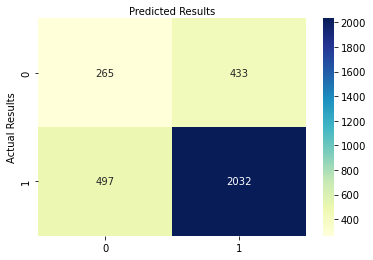

In [58]:
# ---+ step 7 get the confusion matrix
y_pred_rf_tune = rf.predict(test_x_tfidf)   
print('==================')
c_m(y_pred_rf_tune, test_y_tfidf)
print(metrics.classification_report(test_y_tfidf, y_pred_rf_tune))

# 5. Features Engineering

## 5.1. Topic Modelling

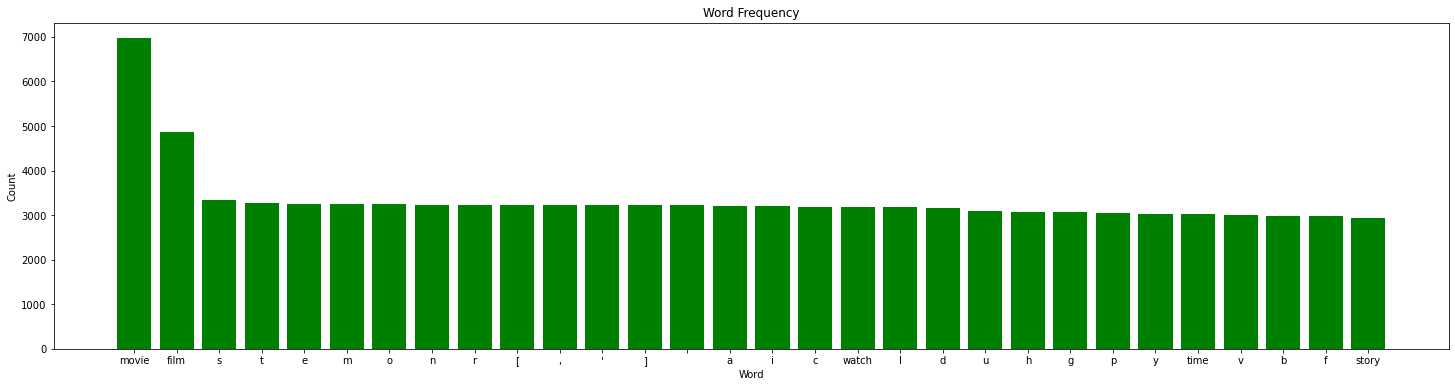

,word,freq
0,movie,6971
1,film,4855
2,s,3347
3,t,3266
4,e,3253
...,...,...
22225,yougreat,1
22226,babyoile,1
22227,cimmeria,1
22228,coverboy,1


In [73]:
temp_token = traintest_xy['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
    
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(25, 6))
plt.bar(word_fr.word[0:30], word_fr.freq[0:30], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()
word_fr

In [74]:
# remove 20 most frequent words which is known in this context
word_list = word_fr.head(20)['word'].to_list()
mdy_list, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_list.append(tmp)
    tmp=[]

traintest_xy['tokens'] = mdy_list

In [75]:
# topic modeling
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram = Phrases(                              
    docs_tokens,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases(                             
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
# docs_phrased

14302


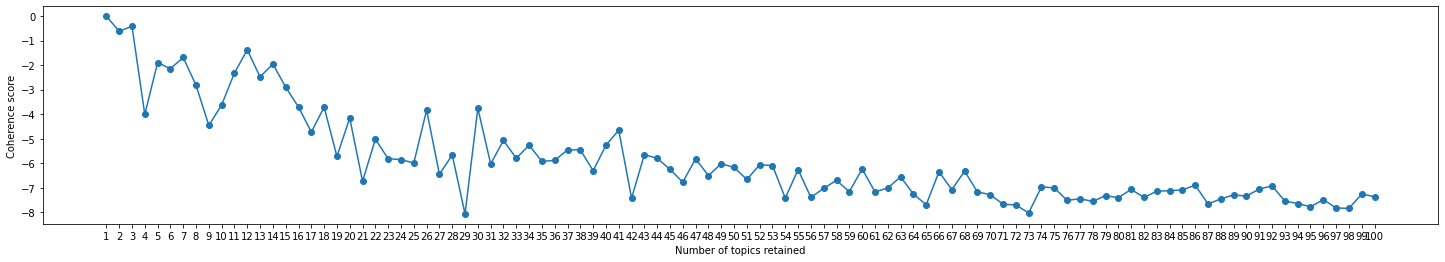

In [76]:
# With Tomotopy, it is necessary to wrap the preprocessed documents in a corpus-like object
# create corpus
corpus = tp.utils.Corpus()                   
for item in docs_phrased:                   
    if item != []:
        corpus.add_doc(words=item)
    else:
        corpus.add_doc(words=" ")
print(len(corpus))

# Explore the fit of surrogate models, i.e. models that retain different numbers of topics.
cvs = {}                                    # step 1 We create an empty dictionary to store the scores of different models.
for topic_number in range(1, 101, 1):        # step 2 We let the number of retained topics vary between models, and for each model we record the associated Coherence Score
    mdl = tp.LDAModel(k=topic_number, corpus=corpus) # our over all words
    for i in range(0, 100, 10): # 100 iterations
        mdl.train(10)
        # print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score() # lower is better

# plot the Coherence Score
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 101, 1))
plt.show()

In [72]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=78, corpus=corpus)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt #.head(1).T

,word,prob,k,sort
0,rocky,0.014,0,0
1,tim,0.013,0,1
2,frank,0.012,0,2
3,diane,0.010,0,3
4,south,0.010,0,4
...,...,...,...,...
775,killer,0.011,77,5
776,prison,0.010,77,6
777,criminal,0.008,77,7
778,ennis,0.007,77,8


In [71]:
# The second outcome of topic modeling we retrieve consists of the topic-to-document probabilities,
#  which we retrieve using the ‘get_topic_dist’ attribute, 
# available for any document included in the LDA corpus used for the training.
# 第二個主題建模的結果是主題到文件概率的預測，
# 這可以使用“get_topic_dist”屬性，可用於訓練 LDA 的資料庫中包含的任何文件。
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_69,topic_70,topic_71,topic_72,topic_73,topic_74,topic_75,topic_76,topic_77,topic_78
0,0.000496,0.000326,0.005273,0.000766,0.000310,0.006192,0.000371,0.001235,0.000324,0.002061,...,0.000304,0.000815,0.000311,0.000284,0.122294,0.000233,0.000324,0.000774,0.000389,0.000707
1,0.000213,0.000140,0.391039,0.000329,0.000133,0.054498,0.000159,0.000531,0.000139,0.052722,...,0.000131,0.000350,0.000134,0.000122,0.000726,0.000100,0.000139,0.000333,0.000167,0.000304
2,0.000278,0.000183,0.002956,0.000429,0.000174,0.003471,0.000208,0.000692,0.000182,0.136368,...,0.000170,0.000457,0.000174,0.000159,0.000946,0.000131,0.000182,0.000434,0.000218,0.000396
3,0.000269,0.000177,0.002859,0.000415,0.000168,0.003358,0.000201,0.000670,0.000176,0.131909,...,0.000165,0.000442,0.000168,0.000154,0.000916,0.000126,0.000176,0.000420,0.000211,0.000383
4,0.000166,0.000109,0.001763,0.000256,0.000104,0.163417,0.000124,0.000413,0.000109,0.000689,...,0.000102,0.000272,0.000104,0.000095,0.000565,0.000078,0.060613,0.000259,0.000130,0.000236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14302,0.000016,0.000011,0.000175,0.000025,0.000010,0.000205,0.000012,0.000041,0.000011,0.000068,...,0.000010,0.000027,0.000010,0.000009,0.000056,0.000008,0.000011,0.000026,0.000013,0.000023
14303,0.000017,0.000011,0.000183,0.000027,0.000011,0.000215,0.000013,0.000043,0.000011,0.000072,...,0.000011,0.000028,0.000011,0.000010,0.000059,0.000008,0.000011,0.000027,0.000014,0.000025
14304,0.000017,0.000011,0.000178,0.000026,0.000010,0.000208,0.000012,0.000042,0.000011,0.000069,...,0.000010,0.000027,0.000010,0.000010,0.000057,0.000008,0.000011,0.000026,0.000013,0.000024
14305,0.000024,0.000016,0.000256,0.000037,0.000015,0.000301,0.000018,0.000060,0.000016,0.000100,...,0.000015,0.000040,0.000015,0.000014,0.000082,0.000011,0.000016,0.000038,0.000019,0.000034


In [70]:
# # save the wt and td to csv
# wt.to_csv("wt.csv", index=False)
# td.to_csv("td.csv", index=False)
# read the csv
wt = pd.read_csv("wt.csv")
td = pd.read_csv("td.csv")

## 5.2. Semtiment Analysis

In [62]:
# clean text
def process_text(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    #text = text.str
    text = str(text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'#', '', text)
    text = text.replace(':', '')
    text = text.replace('(', '')
    text = text.replace(')', '')
    text = text.replace('.', '')
    text = text.replace('“', '')
    text = text.replace('”', '')
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    text_tokens = tokenizer.tokenize(text)

    text_clean = []
    for word in text_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation): 
            stem_word = stemmer.stem(word)  # stemming word
            text_clean.append(stem_word)
            
    sentence = ' '.join(text_clean)
    
    return sentence

# categorical label
def cat_label(label):
    if label == 'neg':
        value = -1
    elif label == 'pos':
        value = 1
    return value 

# split for x and y 
def xy(dataset):
    df = pd.DataFrame(dataset, columns = ['text', 'label'])
    df['text_clean'] = df['text'].apply(lambda x: preprocess(x))
    df['text_clean'] = df['text'].apply(lambda x: process_text(x))  #preprocess
    #df['categorical_label'] = df.label.factorize()[0]
    df['categorical_label'] = df['label'].apply(lambda x: cat_label(x))

    x = df.text_clean
    y = df.categorical_label

    return x, y

In [63]:
# documents
docs_negative = [(t, "neg") for t in twitter_samples.strings("negative_tweets.json")]
docs_positive = [(t, "pos") for t in twitter_samples.strings("positive_tweets.json")]
print("==========================================================")
print(f'There are {len(docs_negative)} negative sentences.')
print(f'There are {len(docs_positive)} positive sentences.')

# spliting dataset 
train_set = docs_negative[:3500] + docs_positive[:3500]
test_set = docs_negative[3500:4250] + docs_positive[3500:4250]
valid_set = docs_negative[4250:] + docs_positive[4250:]

# dataframe
x_train, y_train = xy(train_set)
x_test, y_test = xy(test_set)
x_valid, y_valid = xy(valid_set)

## using the naive bayes classifier
model = Pipeline([
    ('bow',CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print("==========================================================")
print(confusion_matrix(y_pred,y_test))
print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred,y_test))

There are 5000 negative sentences.
There are 5000 positive sentences.
[[594 237]
 [156 513]]
              precision    recall  f1-score   support

          -1       0.79      0.71      0.75       831
           1       0.68      0.77      0.72       669

    accuracy                           0.74      1500
   macro avg       0.74      0.74      0.74      1500
weighted avg       0.74      0.74      0.74      1500

0.738


In [64]:
# Apply into traintest_xy['imdb_user_review_clean]
# clean text for sentiment analysis again
traintest_xy['imdb_user_review_clean'] = traintest_xy['imdb_user_review_clean'].apply(lambda x: process_text(x))
# making prediction
prediction = model.predict(traintest_xy.imdb_user_review_clean)
prediction_label = np.array(['positive' if p==1 else 'negative' for p in prediction])
traintest_xy['prediction_label'] = prediction_label
traintest_xy['sentiment_score'] = prediction
# df_sentence.head()
print("==========================================================")
print(Counter(traintest_xy['prediction_label']))
traintest_xy.head()

Counter({'positive': 7901, 'negative': 6401})


,imdb_user_review,imdb_user_review_clean,token,helpfulness_cat,token_len,prediction_label,sentiment_score
0,"I watched this movie and three years later, it...",watch movi three year later still good actor g...,"[watch, movie, year, good, actor, good, wither...",1.0,15,positive,1
1,...This movie would be a real treat...I enjoy'...,movi would real treati enjoyd movi realli much...,"[movie, real, treat, movie, wonder, good, movi...",1.0,37,negative,-1
2,Take everything good about the 1st X-men movie...,take everyth good 1st xmen movi sprinkl dash m...,"[good, x, man, movie, sprinkle, dash, maise, w...",1.0,28,negative,-1
3,"Finn was terrible, Rey was terrible. They even...",finn terribl rey terribl even made yoda terrib...,"[finn, terrible, rey, terrible, yoda, terrible...",1.0,29,negative,-1
4,I've seen this movie more times than I can cou...,ive seen movi time count cri everi time first ...,"[movie, time, count, time, theater, root, win,...",1.0,48,positive,1


## 5.3. Word-Length Count

In [71]:
# create column for length analysis outcome
traintest_xy['word_count'] = traintest_xy["token"].apply(lambda x: len(x))
traintest_xy['char_count'] = traintest_xy["token"].apply(lambda x: sum(len(word) for word in x))
traintest_xy['sentence_count']  = traintest_xy['imdb_user_review'].apply(lambda x: len(str(x).split(".")))
traintest_xy['avg_word_length'] = traintest_xy['char_count'] / traintest_xy['word_count']
traintest_xy['avg_sentence_length'] = traintest_xy['word_count'] / traintest_xy['sentence_count']
traintest_xy.head()

,imdb_user_review,helpfulness_cat,imdb_user_review_clean,token,token_len,prediction_label,sentiment_score,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,"I watched this movie and three years later, it...",1.0,watch movi three year later still good actor g...,"[watch, movie, year, good, actor, good, wither...",15,positive,1,15,79,4,5.266667,3.750000
1,...This movie would be a real treat...I enjoy'...,1.0,movi would real treati enjoyd movi realli much...,"[movie, real, treat, movie, wonder, good, movi...",37,negative,-1,37,196,21,5.297297,1.761905
2,Take everything good about the 1st X-men movie...,1.0,take everyth good 1st xmen movi sprinkl dash m...,"[good, x, man, movie, sprinkle, dash, maise, w...",28,negative,-1,28,138,1,4.928571,28.000000
3,"Finn was terrible, Rey was terrible. They even...",1.0,finn terribl rey terribl even made yoda terrib...,"[finn, terrible, rey, terrible, yoda, terrible...",29,negative,-1,29,158,6,5.448276,4.833333
4,I've seen this movie more times than I can cou...,1.0,ive seen movi time count cri everi time first ...,"[movie, time, count, time, theater, root, win,...",48,positive,1,48,254,8,5.291667,6.000000


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


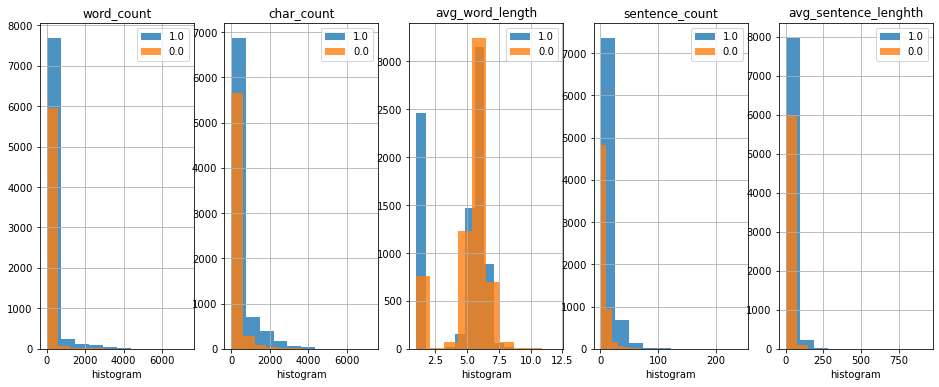

In [72]:
# visualize the distribution of the dataset
import seaborn as sns
x1,x2,x3,x4,x5,y = "word_count","char_count","avg_word_length","sentence_count","avg_sentence_length", "helpfulness_cat"
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(16,6))
for i in traintest_xy[y].unique():
    sns.distplot(traintest_xy[traintest_xy[y]==i][x1], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(traintest_xy[traintest_xy[y]==i][x2], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[1])
    sns.distplot(traintest_xy[traintest_xy[y]==i][x3], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[2])
    sns.distplot(traintest_xy[traintest_xy[y]==i][x4], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[3])
    sns.distplot(traintest_xy[traintest_xy[y]==i][x5], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[4])
ax[0].grid(True)
ax[0].legend(traintest_xy[y].unique())
ax[0].set_title("word_count")
ax[1].grid(True)
ax[1].legend(traintest_xy[y].unique())
ax[1].set_title("char_count")
ax[2].grid(True)
ax[2].legend(traintest_xy[y].unique())
ax[2].set_title("avg_word_length")
ax[3].grid(True)
ax[3].legend(traintest_xy[y].unique())
ax[3].set_title("sentence_count")
ax[4].grid(True)
ax[4].legend(traintest_xy[y].unique())
ax[4].set_title("avg_sentence_lenghth")
plt.show()

# 6. Compiling those features to models

## 6.1. vector and features
We would use the best vector + new adding features to train the models, including:
- topic modelling
- sentiment analysis
- sentence length & word count

In [57]:
# td drop index 8850, 9727, 10571, 10957, 11069
td.drop(index=[8850, 9727, 10571, 10957, 11069], inplace=True) # null token inside
# reset index
td.reset_index(drop=True, inplace=True)

In [86]:
# concat td and traintest_xy_bow
traintest_xy_tfidf_feature = pd.concat([
    td,
    df_tfidfvect,
    traintest_xy[[
        "helpfulness_cat",
        "sentiment_score",
        "word_count",
        "char_count",
        "sentence_count",
        "avg_word_length",
        "avg_sentence_length"
    ]]
    ], axis=1)

traintest_xy_tfidf_feature

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,zurg,zvyagintsev,zwick,helpfulness_cat,sentiment_score,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,0.000496,0.000326,0.005273,0.000766,0.000310,0.006192,0.000371,0.001235,0.000324,0.002061,...,0.0,0.0,0.0,1.0,1,15,79,4,5.266667,3.750000
1,0.000213,0.000140,0.391039,0.000329,0.000133,0.054498,0.000159,0.000531,0.000139,0.052722,...,0.0,0.0,0.0,1.0,-1,37,196,21,5.297297,1.761905
2,0.000278,0.000183,0.002956,0.000429,0.000174,0.003471,0.000208,0.000692,0.000182,0.136368,...,0.0,0.0,0.0,1.0,-1,28,138,1,4.928571,28.000000
3,0.000269,0.000177,0.002859,0.000415,0.000168,0.003358,0.000201,0.000670,0.000176,0.131909,...,0.0,0.0,0.0,1.0,-1,29,158,6,5.448276,4.833333
4,0.000166,0.000109,0.001763,0.000256,0.000104,0.163417,0.000124,0.000413,0.000109,0.000689,...,0.0,0.0,0.0,1.0,1,48,254,8,5.291667,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14297,0.000016,0.000011,0.000175,0.000025,0.000010,0.000205,0.000012,0.000041,0.000011,0.000068,...,0.0,0.0,0.0,1.0,-1,499,499,10,1.000000,49.900000
14298,0.000017,0.000011,0.000183,0.000027,0.000011,0.000215,0.000013,0.000043,0.000011,0.000072,...,0.0,0.0,0.0,0.0,1,475,475,8,1.000000,59.375000
14299,0.000017,0.000011,0.000178,0.000026,0.000010,0.000208,0.000012,0.000042,0.000011,0.000069,...,0.0,0.0,0.0,1.0,-1,491,491,14,1.000000,35.071429
14300,0.000024,0.000016,0.000256,0.000037,0.000015,0.000301,0.000018,0.000060,0.000016,0.000100,...,0.0,0.0,0.0,1.0,1,340,340,4,1.000000,85.000000


## 6.2. Standardization

In [65]:
# # save traintest_xy_tfidf_feature to csv
# traintest_xy_tfidf_feature.to_csv("traintest_xy_tfidf_feature.csv", index=False)
# read the csv file
traintest_xy_tfidf_feature = pd.read_csv("traintest_xy_tfidf_feature.csv")

In [66]:
traintest_x_tfidf_feature = traintest_xy_tfidf_feature.drop(["helpfulness_cat"], axis=1)
traintest_y_tfidf_feature = traintest_xy_tfidf_feature["helpfulness_cat"]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(traintest_x_tfidf_feature)
traintest_x_tfidf_feature = scaler.transform(traintest_x_tfidf_feature)
traintest_x_tfidf_feature = pd.DataFrame(traintest_x_tfidf_feature)

# unzip
train_x_tfidf_feature,test_x_tfidf_feature = traintest_x_tfidf_feature.iloc[:11075,:],traintest_x_tfidf_feature.iloc[11075:,:]
train_y_tfidf_feature,test_y_tfidf_feature = traintest_y_tfidf_feature[0:11075],traintest_y_tfidf_feature[11075:14302]

## 6.3. Prediction Model

### 6.3.1. Logistic Regression, Decision Tree, and Random Forest

Logistic Regression:

train R^2 = 0.9848306997742664


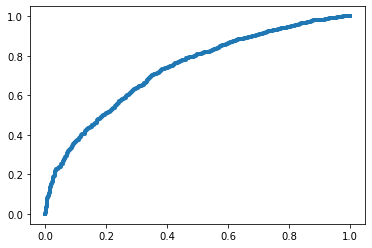

test roc_auc_score 0.7317116800562202
test Threshold =  0.5147358319979864
Model's Accuracy: 0.6885652308645801
Model's Misclassification: 0.3114347691354199
Model's Specificity: 0.6482939632545932
Model's Sensitivity: 0.7010141987829615
              precision    recall  f1-score   support

         0.0       0.40      0.65      0.50       762
         1.0       0.87      0.70      0.77      2465

    accuracy                           0.69      3227
   macro avg       0.63      0.67      0.64      3227
weighted avg       0.76      0.69      0.71      3227



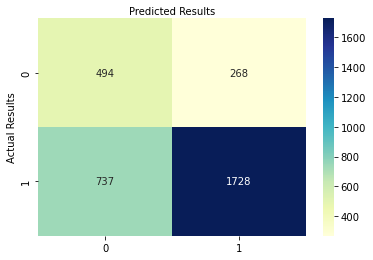

In [108]:
logistic_regression(train_x_tfidf_feature, test_x_tfidf_feature, train_y_tfidf_feature, test_y_tfidf_feature)

Decision Tree

Accuracy is  35.35791757049891


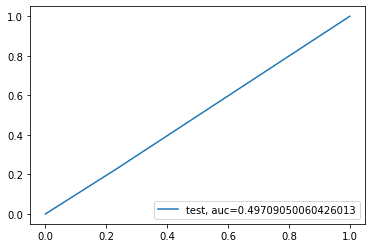

Accuracy score (train set) = 1.0000
Accuracy score (test set) = 0.3536
F1 score (test set) = 0.3473
AUC score (test set) = 0.4971
Model's Accuracy: 0.35357917570498915
Model's Misclassification: 0.6464208242950108
Model's Specificity: 0.23477564102564102
Model's Sensitivity: 0.759233926128591
              precision    recall  f1-score   support

         0.0       0.23      0.77      0.36       762
         1.0       0.76      0.23      0.35      2465

    accuracy                           0.35      3227
   macro avg       0.50      0.50      0.35      3227
weighted avg       0.64      0.35      0.35      3227



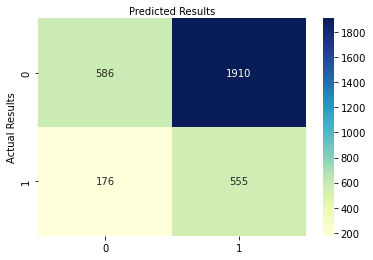

In [67]:
decision_tree(train_x_tfidf_feature, test_x_tfidf_feature, train_y_tfidf_feature, test_y_tfidf_feature)

Random Forest

Unoptimised Tree Accuracy
Model's Accuracy: 0.7561202355128602
Model's Misclassification: 0.24387976448713977
Model's Specificity: 0.3563218390804598
Model's Sensitivity: 0.7671974522292994
              precision    recall  f1-score   support

         0.0       0.36      0.04      0.07       762
         1.0       0.77      0.98      0.86      2465

    accuracy                           0.76      3227
   macro avg       0.56      0.51      0.47      3227
weighted avg       0.67      0.76      0.67      3227



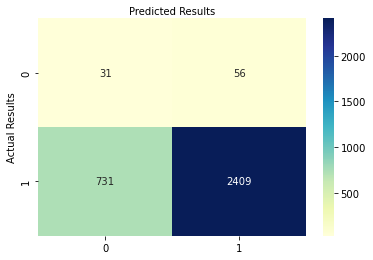

In [68]:
random_forest(train_x_tfidf_feature, test_x_tfidf_feature, train_y_tfidf_feature, test_y_tfidf_feature)

### 6.3.2. Neural network

In [9]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(traintest_x_tfidf_feature, traintest_y_tfidf_feature)
model = SelectFromModel(lsvc, prefit=True)
X_train_new = model.transform(train_x_tfidf_feature)
X_test_new = model.transform(test_x_tfidf_feature)
X_train_new.shape

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(11075, 33)

In [30]:
# clear cache and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

# build a hyper parameter function to tune the parameters
def train_model_hp(hp):
  
    model = tf.keras.models.Sequential()

    # tune 1st layer  
    model.add(tf.keras.layers.Dense(units=hp.Int("1st_layer_units", min_value=30, max_value=70), 
      kernel_initializer = 'uniform',
      activation="relu", 
      input_shape=train_x_tfidf_feature.shape[1:]))

    # tune 1st drop out rate
    model.add(tf.keras.layers.Dropout(rate=hp.Float('1st_dropout_rate', min_value = 0.1, max_value=0.2)))

    # tune 2nd layer 
    model.add(tf.keras.layers.Dense(units=hp.Int(f"2nd_num_units", min_value = 20, max_value=40), activation='relu'))

    # tune 2nd drop out rate
    model.add(tf.keras.layers.Dropout(rate=hp.Float('2nd_dropout_rate', min_value = 0.1, max_value=0.2)))

    # tune 3rd layer 
    model.add(tf.keras.layers.Dense(units=hp.Int(f"3rd_num_units", min_value = 5, max_value=20), activation='relu'))
            
    # add output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # define a choice of optimizer 
    optim_algo = hp.Choice('optimizer', values=['sgd','adam'])
    # define the range of learning rate 
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # tune wether to use sgd or adam optimizer 
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # compile the model   
    model.compile(  optimizer=optimizer,
                    # add loss function, in this case, the result will be binary 
                    loss='binary_crossentropy',
                    # define metrics to show 
                    metrics=["accuracy"])

    return model

train_model_hp(kt.HyperParameters())

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# create tuner
tuner = kt.Hyperband(train_model_hp,
                     # set an obejective of minimise loss
                     objective='val_accuracy',
                     max_epochs=70,
                     factor=3,
                     seed=235,
                     directory='/Users/user/Desktop',
                     project_name='tuner'
                    )

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# find the best values
tuner.search(train_x_tfidf_feature, 
             train_y_tfidf_feature,
             epochs=50, 
             # val_loss
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)],
             validation_data=(test_x_tfidf_feature,test_y_tfidf_feature)
             )

Trial 90 Complete [00h 02m 08s]
val_accuracy: 0.7449643611907959

Best val_accuracy So Far: 0.7641772627830505
Total elapsed time: 01h 19m 56s
INFO:tensorflow:Oracle triggered exit


In [33]:
# get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'1st_layer_units': 52, '1st_dropout_rate': 0.17873297816287664, '2nd_num_units': 28, '2nd_dropout_rate': 0.12803759295424227, '3rd_num_units': 8, 'optimizer': 'sgd', 'learning_rate': 0.00012045060648884652, 'tuner/epochs': 8, 'tuner/initial_epoch': 3, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': 'b70515457391d8ee3321f164c70603c1'}


/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

# create the best model
model_modify = tuner.hypermodel.build(best_hps)
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

#create another model
log_modify = model_modify.fit(train_x_tfidf_feature, train_y_tfidf_feature,
               epochs=100,
              # shuffle=True,
               batch_size=72,
               validation_data=(test_x_tfidf_feature,test_y_tfidf_feature),
                # callbacks=[early_stopping_cb]
                )

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/100
154/154 [==============================] - 10s 64ms/step - loss: 0.6897 - accuracy: 0.5200 - val_loss: 0.6716 - val_accuracy: 0.7022
Epoch 2/100
154/154 [==============================] - 3s 22ms/step - loss: 0.6894 - accuracy: 0.5235 - val_loss: 0.6714 - val_accuracy: 0.7028
Epoch 3/100
154/154 [==============================] - 3s 22ms/step - loss: 0.6898 - accuracy: 0.5153 - val_loss: 0.6712 - val_accuracy: 0.7034
Epoch 4/100
154/154 [==============================] - 3s 22ms/step - loss: 0.6894 - accuracy: 0.5242 - val_loss: 0.6711 - val_accuracy: 0.7056
Epoch 5/100
154/154 [==============================] - 3s 22ms/step - loss: 0.6897 - accuracy: 0.5208 - val_loss: 0.6709 - val_accuracy: 0.7062
Epoch 6/100
154/154 [==============================] - 3s 21ms/step - loss: 0.6892 - accuracy: 0.5230 - val_loss: 0.6707 - val_accuracy: 0.7084
Epoch 7/100
154/154 [==============================] - 3s 21ms/step - loss: 0.6895 - accuracy: 0.5177 - val_loss: 0.6706 - val_accuracy

In [36]:
model_modify.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 52)                2084420   
                                                                 
 dropout (Dropout)           (None, 52)                0         
                                                                 
 dense_1 (Dense)             (None, 28)                1484      
                                                                 
 dropout_1 (Dropout)         (None, 28)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 232       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,086,145
Trainable params: 2,086,145
Non-

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


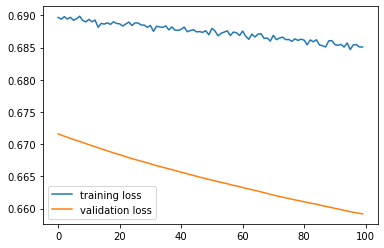

In [37]:
# visualise the loss
plt.plot(log_modify.history['loss'],label = "training loss")
plt.plot(log_modify.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

In [47]:
# clean sessions and set random seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

# create tensorflow model
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Dense(150, kernel_initializer = 'uniform',activation="relu", input_shape=train_x_tfidf_feature.shape[1:]),
    # tf.keras.layers.Dropout(0.17873297816287664),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(60,activation="relu"),
    # tf.keras.layers.Dropout(0.12803759295424227),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# compile the model
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.00012045060648884652),
              metrics=["accuracy"])

# keep track of the performance
log = model.fit(train_x_tfidf_feature, train_y_tfidf_feature, 
                epochs=100, 
                validation_data=(test_x_tfidf_feature, test_y_tfidf_feature),
               )

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/100
347/347 [==============================] - 14s 38ms/step - loss: 0.6924 - accuracy: 0.5142 - val_loss: 0.6866 - val_accuracy: 0.6337
Epoch 2/100
347/347 [==============================] - 6s 18ms/step - loss: 0.6923 - accuracy: 0.5124 - val_loss: 0.6861 - val_accuracy: 0.6390
Epoch 3/100
347/347 [==============================] - 7s 20ms/step - loss: 0.6923 - accuracy: 0.5145 - val_loss: 0.6857 - val_accuracy: 0.6511
Epoch 4/100
347/347 [==============================] - 7s 21ms/step - loss: 0.6922 - accuracy: 0.5143 - val_loss: 0.6853 - val_accuracy: 0.6588
Epoch 5/100
347/347 [==============================] - 7s 20ms/step - loss: 0.6921 - accuracy: 0.5130 - val_loss: 0.6849 - val_accuracy: 0.6622
Epoch 6/100
347/347 [==============================] - 7s 19ms/step - loss: 0.6921 - accuracy: 0.5130 - val_loss: 0.6844 - val_accuracy: 0.6709
Epoch 7/100
347/347 [==============================] - 7s 19ms/step - loss: 0.6920 - accuracy: 0.5124 - val_loss: 0.6840 - val_accuracy

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


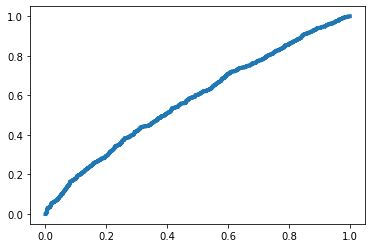

test roc_auc_score 0.57954965314934
test Threshold =  0.52733815


In [49]:
predictions_prob_val = model.predict(test_x_tfidf_feature)
predictions_prob_val

fpr, tpr, thresholds = metrics.roc_curve(test_y_tfidf_feature,predictions_prob_val)

plt.plot(fpr, tpr, linewidth=4)
plt.show()
#check the ROC score
print('test roc_auc_score',roc_auc_score(test_y_tfidf_feature,predictions_prob_val))
# get the threshold
threshold = thresholds[np.argmax(tpr - fpr)]
print("test Threshold = ",threshold)

Y_pred_val = pd.DataFrame(np.where(predictions_prob_val > threshold, 1, 0))

In [79]:
test_y_tfidf_feature

11075    1.0
11076    1.0
11077    1.0
11078    1.0
11079    1.0
        ... 
14297    1.0
14298    0.0
14299    1.0
14300    1.0
14301    0.0
Name: helpfulness_cat, Length: 3227, dtype: float64

In [80]:
# Creating the confusion matrix for the benchmarking and other models using
def c_m(y_test, y_pred):
    # Creating the confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Visualizing the Confusion Matrix
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.ylabel('Actual Results')
    plt.xlabel('Predicted Results')
    ax1.xaxis.set_label_position("top")

    print("Model's Accuracy:", (TP+TN)/(TN+TP+FN+FP))
    print("Model's Misclassification:", (FP+FN)/(TN+TP+FN+FP))
    print("Model's Specificity:", TN/(FP+TN))
    print("Model's Sensitivity:", TP/(TP+FN))
    print(metrics.classification_report(y_test, y_pred))

Model's Accuracy: 0.49612643321970873
Model's Misclassification: 0.5038735667802913
Model's Specificity: 0.6876640419947506
Model's Sensitivity: 0.43691683569979717
              precision    recall  f1-score   support

         0.0       0.27      0.69      0.39       762
         1.0       0.82      0.44      0.57      2465

    accuracy                           0.50      3227
   macro avg       0.55      0.56      0.48      3227
weighted avg       0.69      0.50      0.53      3227



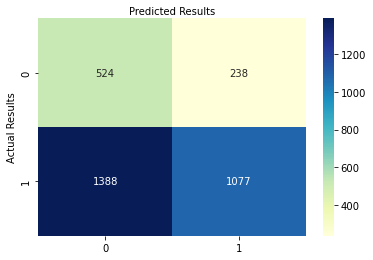

In [81]:
c_m(test_y_tfidf_feature, Y_pred_val)

# 8. Other Method: BERT
We ran it seperately on the google colab, in order to use the BERT model.
Please see the File2_SMM694_NLP_FCP_Group4.ipynb for more details. Thank you!
